# Interpreting Deep Learning Models on Image Data

Here we will look at explaining predictions of deep learning models for computer vision, particularly CNNs used in the context of image classification.

Explaining a model prediction in terms of the original input image is harder than explaining the predicition in terms of a higher convolutional layer (because the higher convolutional layer is closer to the output). Here we will use the Gradient Explainer technique from SHAP to explain model predictions

# Load Dependencies

In [31]:
import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import shap
import keras.backend as K
import json
shap.initjs()


def visualize_model_decisions(shap_values, x, labels=None, figsize=(20, 30)):
    
    colors = []
    for l in np.linspace(1, 0, 100):
        colors.append((30./255, 136./255, 229./255,l))
    for l in np.linspace(0, 1, 100):
        colors.append((255./255, 13./255, 87./255,l))
    red_transparent_blue = LinearSegmentedColormap.from_list("red_transparent_blue", colors)

    multi_output = True
    if type(shap_values) != list:
        multi_output = False
        shap_values = [shap_values]

    # make sure labels
    if labels is not None:
        assert labels.shape[0] == shap_values[0].shape[0], "Labels must have same row count as shap_values arrays!"
        if multi_output:
            assert labels.shape[1] == len(shap_values), "Labels must have a column for each output in shap_values!"
        else:
            assert len(labels.shape) == 1, "Labels must be a vector for single output shap_values."

    # plot our explanations
    fig_size = figsize
    fig, axes = plt.subplots(nrows=x.shape[0], ncols=len(shap_values) + 1, figsize=fig_size)
    if len(axes.shape) == 1:
        axes = axes.reshape(1,axes.size)
    for row in range(x.shape[0]):
        x_curr = x[row].copy()

        # make sure
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
            x_curr = x_curr.reshape(x_curr.shape[:2])
        if x_curr.max() > 1:
            x_curr /= 255.
        
        axes[row,0].imshow(x_curr)
        axes[row,0].axis('off')
        
        # get a grayscale version of the image
        if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
            x_curr_gray = (0.2989 * x_curr[:,:,0] + 0.5870 * x_curr[:,:,1] + 0.1140 * x_curr[:,:,2]) # rgb to gray
        else:
            x_curr_gray = x_curr

        if len(shap_values[0][row].shape) == 2:
            abs_vals = np.stack([np.abs(shap_values[i]) for i in range(len(shap_values))], 0).flatten()
        else:
            abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
        max_val = np.nanpercentile(abs_vals, 99.9)
        for i in range(len(shap_values)):
            if labels is not None:
                axes[row,i+1].set_title(labels[row,i])
            sv = shap_values[i][row] if len(shap_values[i][row].shape) == 2 else shap_values[i][row].sum(-1)
            axes[row,i+1].imshow(x_curr_gray, cmap=plt.get_cmap('gray'), alpha=0.15, extent=(-1, sv.shape[0], sv.shape[1], -1))
            im = axes[row,i+1].imshow(sv, cmap=red_transparent_blue, vmin=-max_val, vmax=max_val)
            axes[row,i+1].axis('off')
        
    cb = fig.colorbar(im, ax=np.ravel(axes).tolist(), label="SHAP value", orientation="horizontal", aspect=fig_size[0]/0.2)
    cb.outline.set_visible(False)

# Load a pre-trained CNN - VGG16

In [32]:
model = VGG16(weights='imagenet', include_top=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Load Sample Dataset

In [33]:
X, y = shap.datasets.imagenet50()
len(X), len(y)

(50, 50)

In [0]:
IMAGE_PATH = './cat2.jpg'
img = keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
img = keras.preprocessing.image.img_to_array(img)

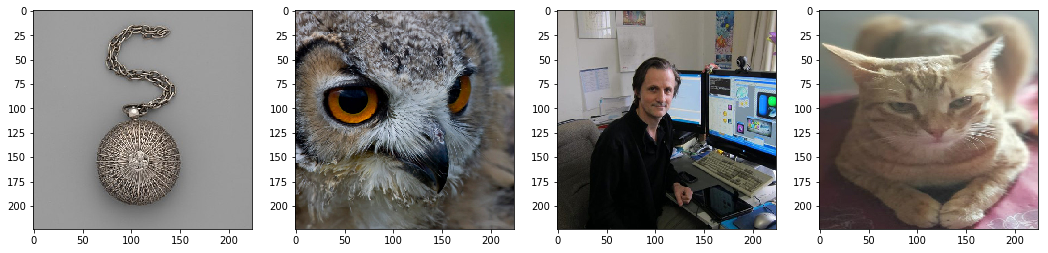

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

to_predict = np.array([X[28], X[35], X[46], img])
fig, ax = plt.subplots(1, 4, figsize=(18, 10))
ax[0].imshow(to_predict[0]/255.)
ax[1].imshow(to_predict[1]/255.)
ax[2].imshow(to_predict[2]/255.)
ax[3].imshow(to_predict[3]/255.)

# Get Model Predictions on Sample Images

In [0]:
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

In [43]:
predictions = model.predict(preprocess_input(to_predict.copy()))
predictions, predictions.shape

(array([[2.1085026e-07, 6.7834230e-07, 1.5247703e-06, ..., 1.3814137e-05,
         2.5486986e-05, 3.4056764e-05],
        [1.4483964e-12, 3.2981451e-11, 7.7344327e-14, ..., 5.6721559e-12,
         6.6913013e-09, 4.7253389e-11],
        [1.8191211e-07, 1.7580450e-07, 2.2195716e-06, ..., 1.7119996e-08,
         4.5716415e-06, 2.3215239e-06],
        [7.4265472e-06, 2.0429092e-05, 6.3075699e-05, ..., 1.3575713e-04,
         1.3192510e-04, 1.8606303e-04]], dtype=float32), (4, 1000))

In [44]:
predicted_labels = [class_names.get(str(pred)) for pred in np.argmax(predictions, axis=1)]
print(predicted_labels)

[['n02999410', 'chain'], ['n01622779', 'great_grey_owl'], ['n03180011', 'desktop_computer'], ['n02124075', 'Egyptian_cat']]


In [0]:
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

In [46]:
model.layers[7].input

<tf.Tensor 'block2_pool_2/MaxPool:0' shape=(?, 56, 56, 128) dtype=float32>

# Use SHAP GradientExplainer to explain model prediction decisions

Combines ideas from Integrated Gradients, SHAP, and SmoothGrad into a single expected value equation. This allows an entire dataset to be used as the background distribution (as opposed to a single reference value) and allows local smoothing. If we approximate the model with a linear function between each background data sample and the current input to be explained, and we assume the input features are independent then expected gradients will compute approximate SHAP values.

We usually get gradients of the class score function with respect to the input image. These gradients can be interpreted as a sensitivity map. Red pixels represent positive SHAP values that increase the probability of the class, while blue pixels represent negative SHAP values the reduce the probability of the class.

## Explain  how the 7th intermediate layer of VGG16 impacts predictions

In [47]:
e = shap.GradientExplainer((model.layers[7].input, model.layers[-1].output), 
                            map2layer(preprocess_input(X.copy()), 7))
shap_values, indexes = e.shap_values(map2layer(to_predict, 7), ranked_outputs=2)
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
index_names

array([['chain', 'chain_mail'],
       ['great_grey_owl', 'prairie_chicken'],
       ['desktop_computer', 'screen'],
       ['Egyptian_cat', 'tabby']], dtype='<U16')

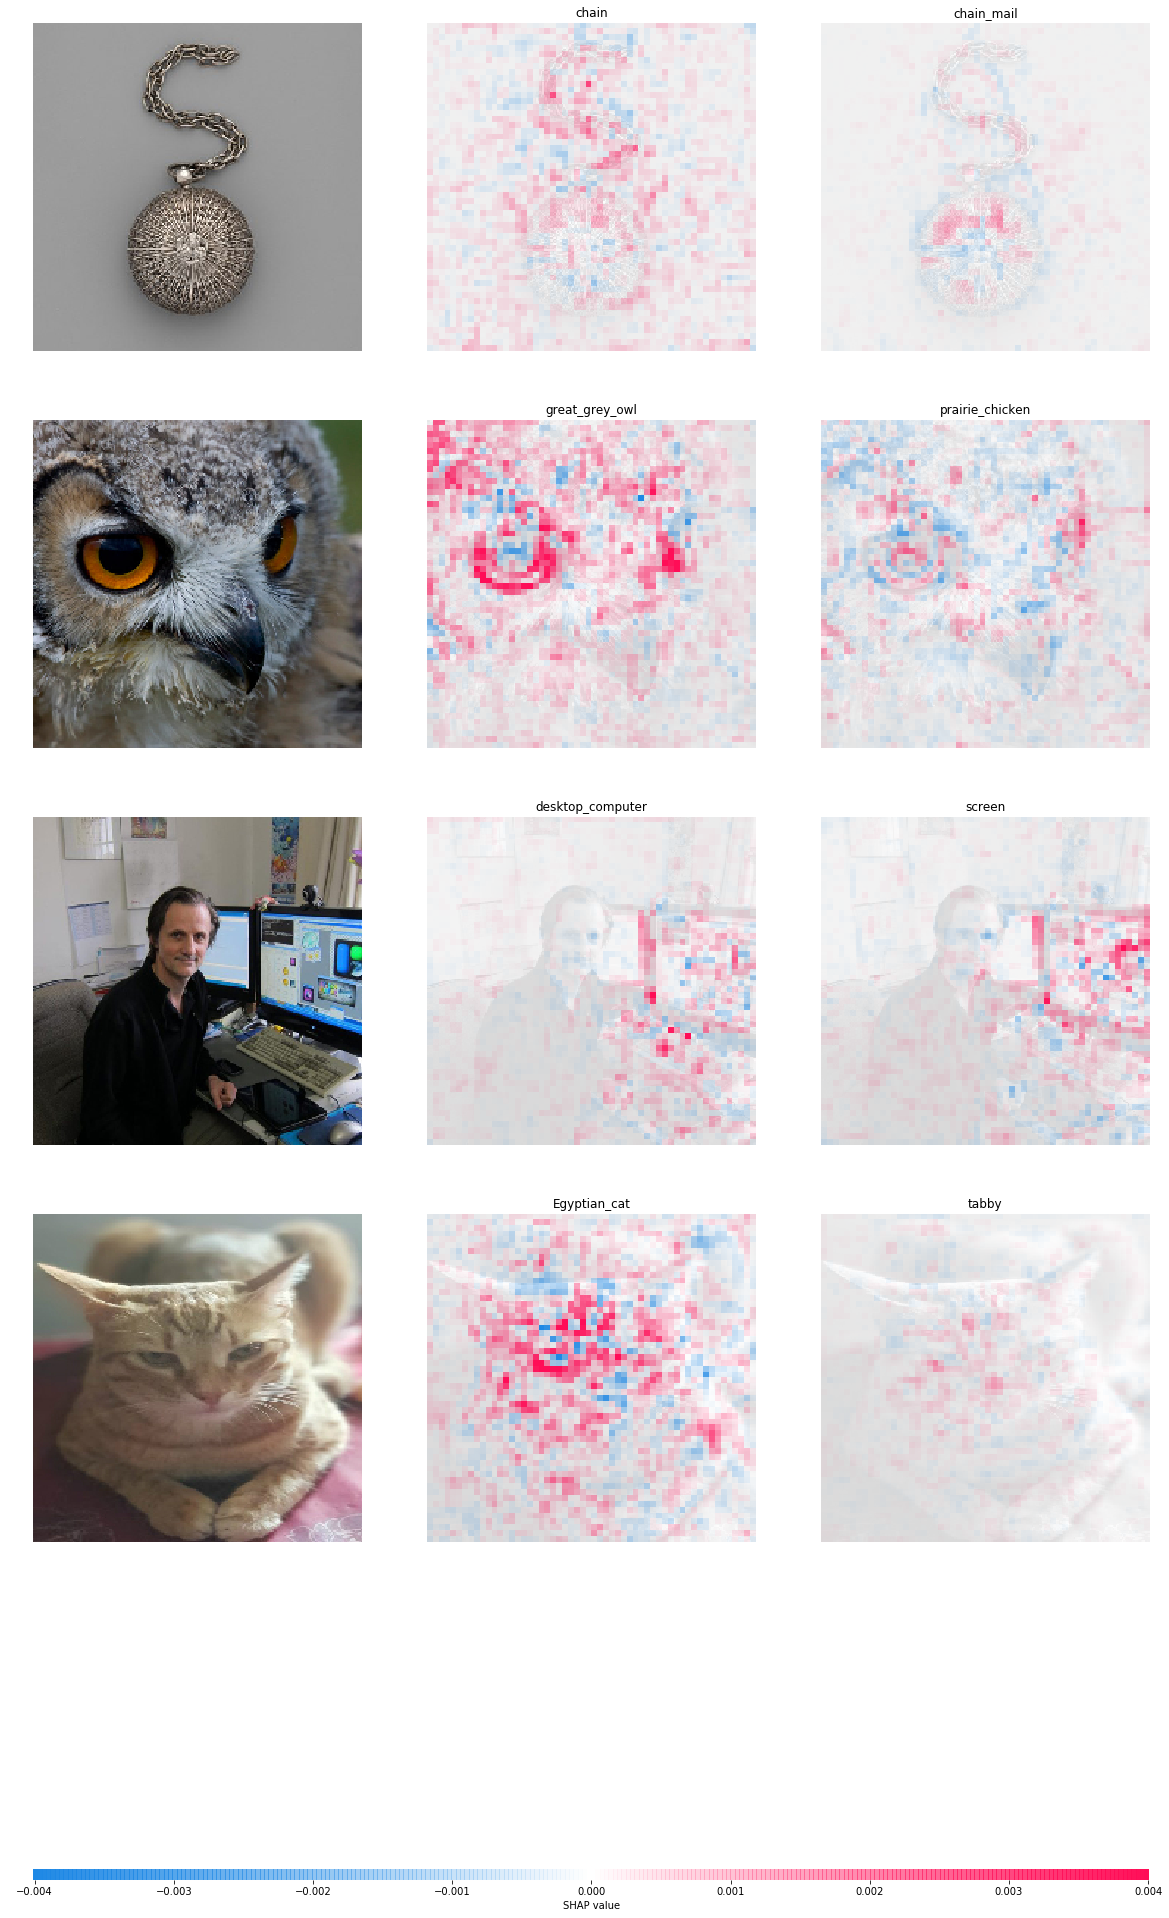

In [48]:
visualize_model_decisions(shap_values=shap_values, x=to_predict, 
                          labels=index_names, figsize=(20, 40))

## Explain  how the 14th intermediate layer of VGG16 impacts predictions

In [49]:
model.layers[14].input

<tf.Tensor 'block4_conv3_2/Relu:0' shape=(?, 28, 28, 512) dtype=float32>

In [50]:
e = shap.GradientExplainer((model.layers[14].input, model.layers[-1].output), 
                            map2layer(preprocess_input(X.copy()), 14))
shap_values, indexes = e.shap_values(map2layer(to_predict, 14), ranked_outputs=2)
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
index_names

array([['chain', 'chain_mail'],
       ['great_grey_owl', 'prairie_chicken'],
       ['desktop_computer', 'screen'],
       ['Egyptian_cat', 'tabby']], dtype='<U16')

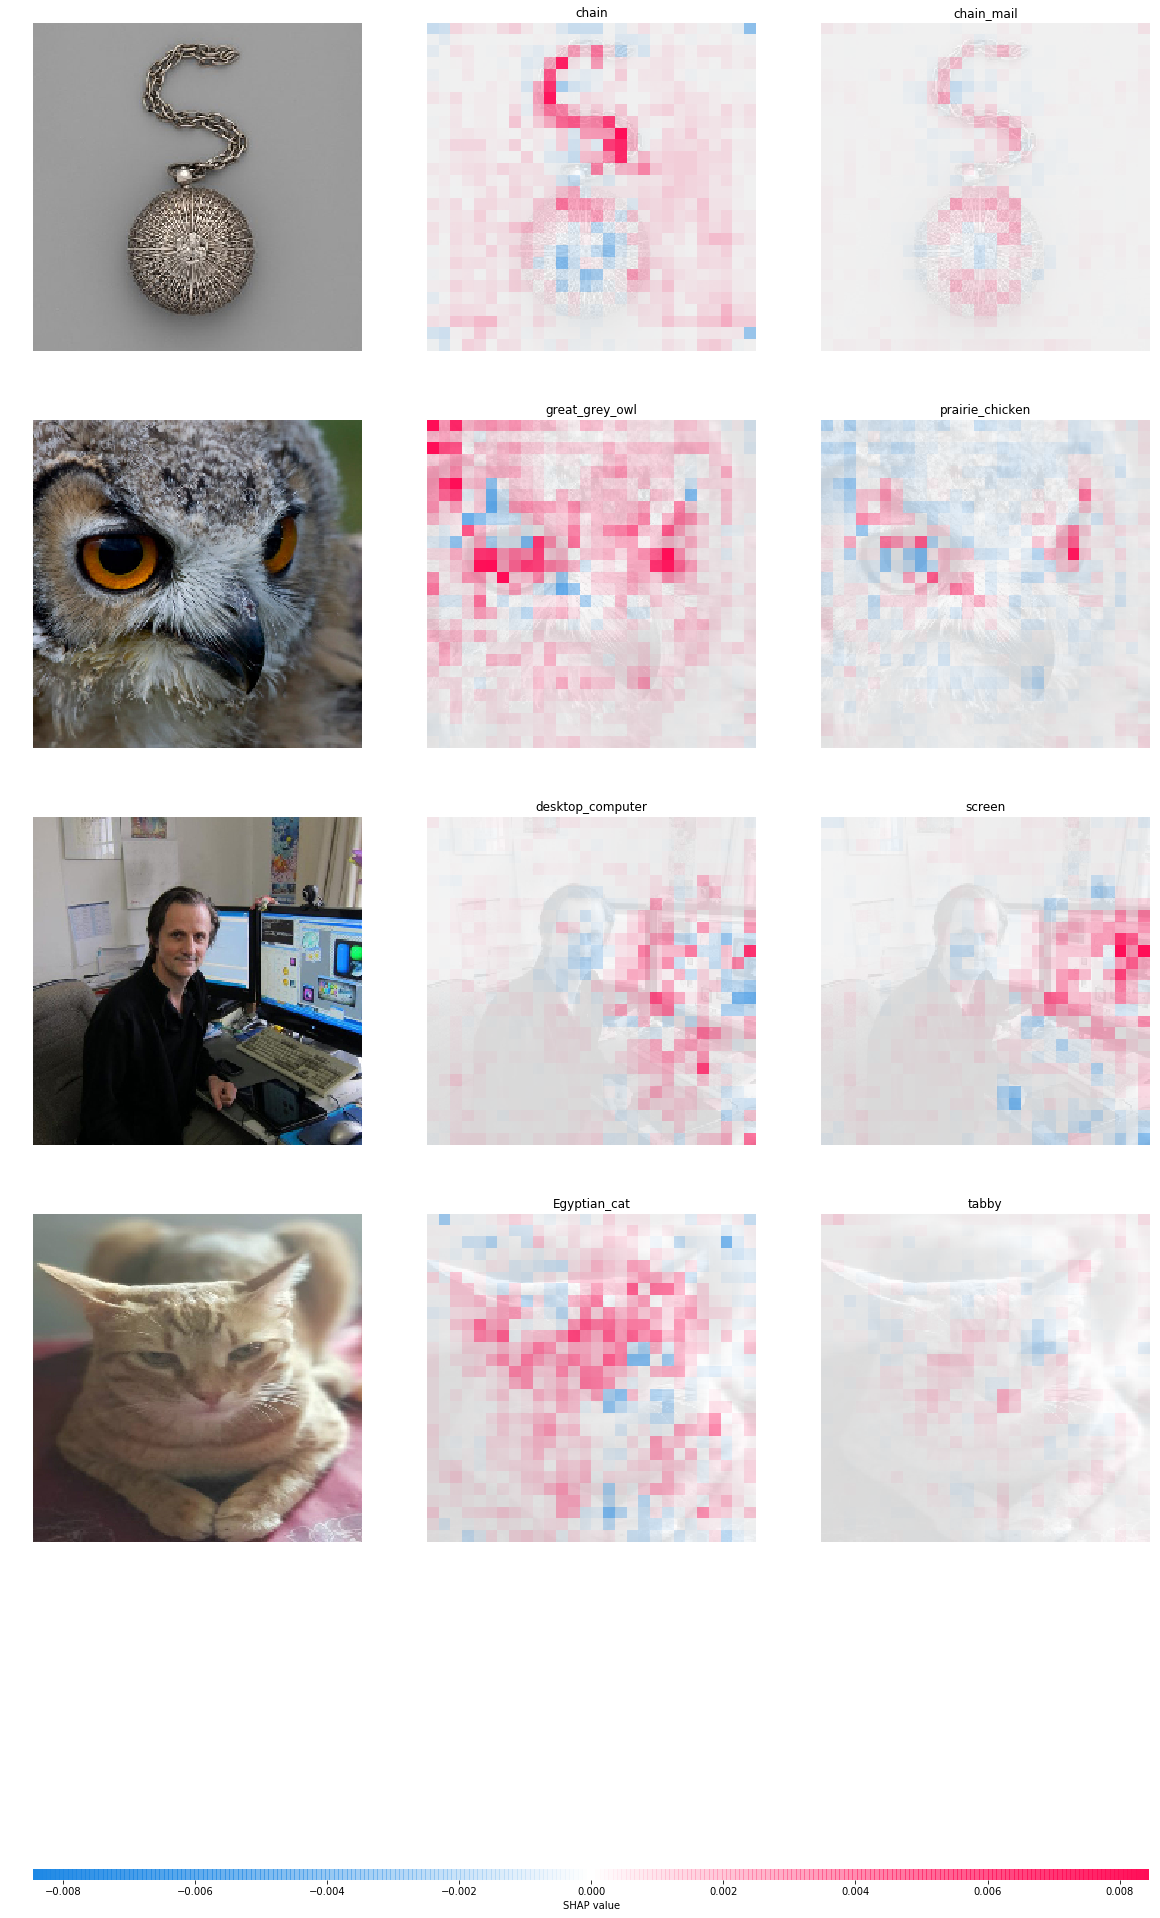

In [52]:
visualize_model_decisions(shap_values=shap_values, x=to_predict, 
                          labels=index_names, figsize=(20, 40))